<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.index.is_monotonic

True

In [4]:
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

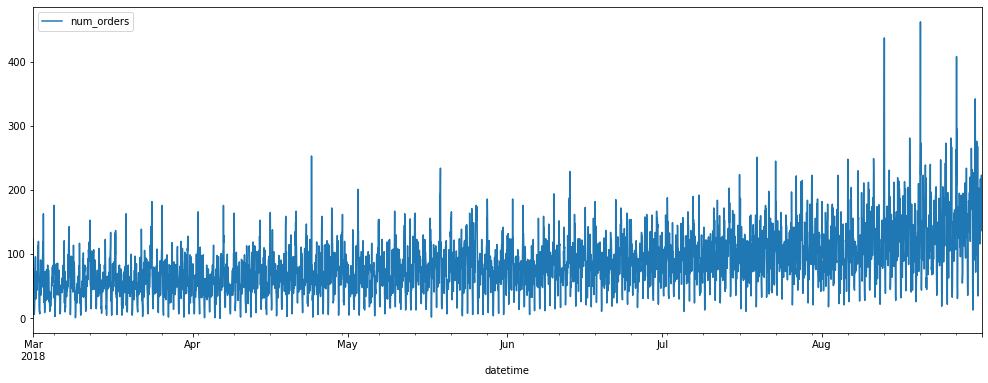

In [6]:
figsize = (17, 6)
data.plot(figsize=figsize)
plt.show()

In [7]:
#data['rolling_mean'] = data.rolling(30).mean()
#data.plot(figsize=figsize)

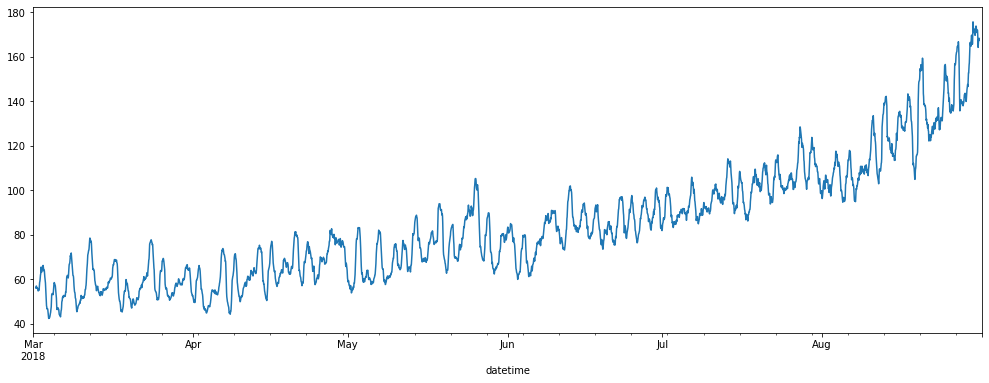

In [8]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=figsize)
plt.show()

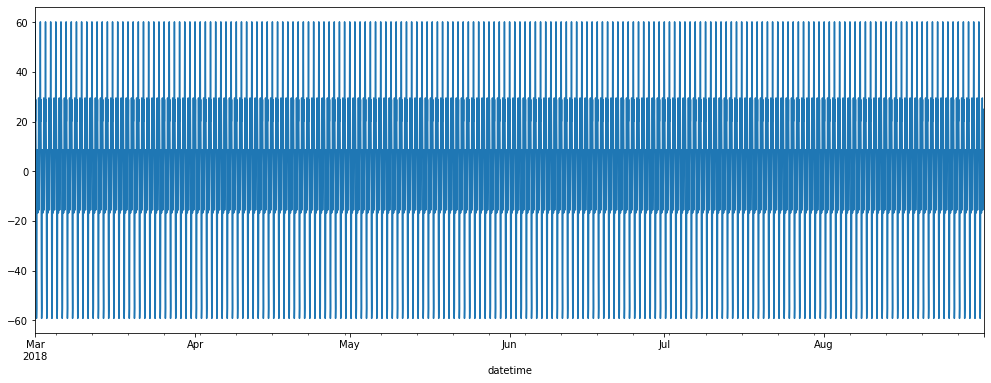

In [9]:
decomposed_data.seasonal.plot(figsize=figsize)
plt.show()

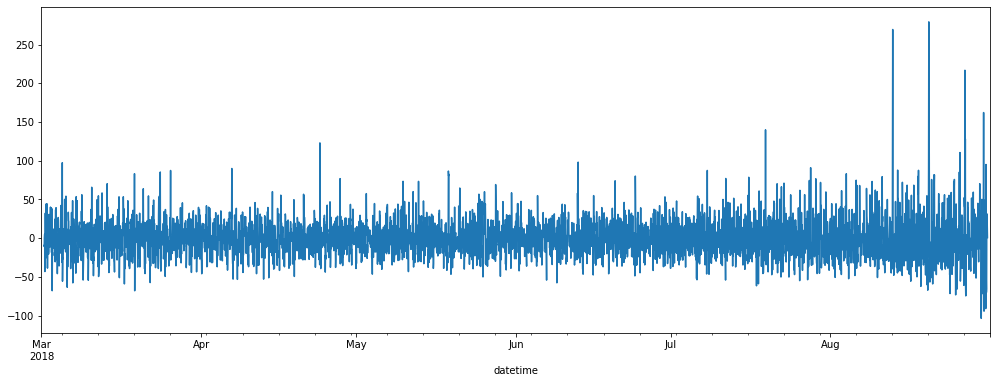

In [10]:
decomposed_data.resid.plot(figsize=figsize)
plt.show()

Разложим последнюю неделю на три составляющие: тренд, сезонность и остаток

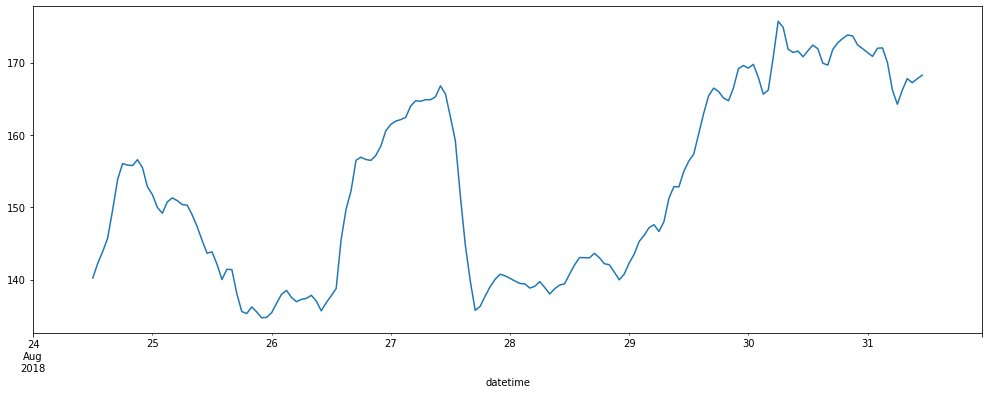

In [11]:
decomposed_data = seasonal_decompose(data['2018-08-24':'2018-08-31'])
decomposed_data.trend.plot(figsize=figsize)
plt.show()

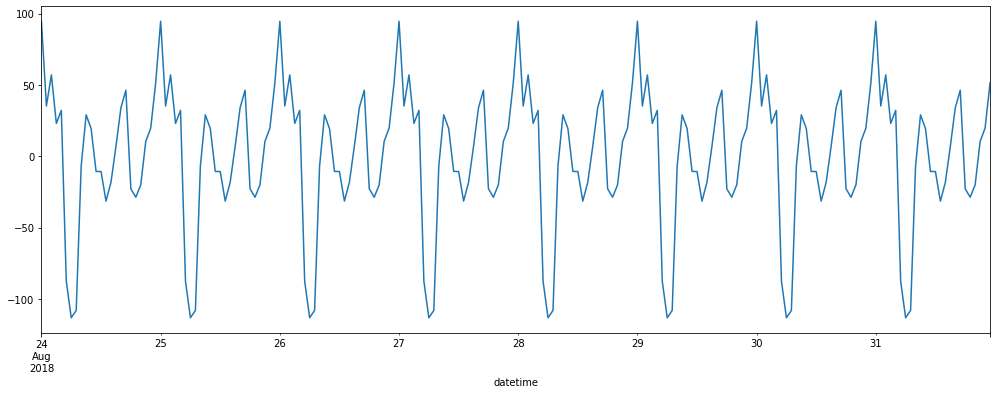

In [12]:
decomposed_data.seasonal.plot(figsize=figsize)
plt.show()

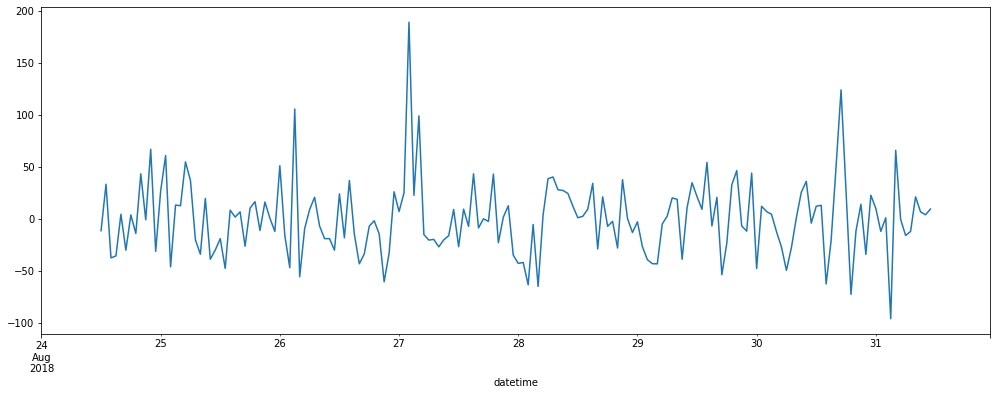

In [13]:
decomposed_data.resid.plot(figsize=figsize)
plt.show()

Создам функцию add_features которая:

- Добавляет фактор месяца и фактор дня исходя из общего тренда
- Добавляет фактор дня недели, так как на графике недели видим большую вариацию
- Добавляет фактор часа, так как прослеживаем пики активности в течении суток 
- Добавляет lag

In [14]:
df = data.copy(deep=True)

In [15]:
def add_features(df, max_lag, rolling_sum_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()
    return df

In [16]:
add_features(df, 47, 50)
df.shape

(4416, 53)

In [17]:
df.head(3)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df = df.dropna()
df.shape

(4366, 53)

In [19]:
df.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,3,3,5,2,108.0,163.0,72.0,119.0,101.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,62.82
2018-03-03 03:00:00,64,3,3,5,3,25.0,108.0,163.0,72.0,119.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,60.84
2018-03-03 04:00:00,44,3,3,5,4,64.0,25.0,108.0,163.0,72.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,60.42
2018-03-03 05:00:00,15,3,3,5,5,44.0,64.0,25.0,108.0,163.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,59.88
2018-03-03 06:00:00,9,3,3,5,6,15.0,44.0,64.0,25.0,108.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,58.86
2018-03-03 07:00:00,17,3,3,5,7,9.0,15.0,44.0,64.0,25.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,58.18
2018-03-03 08:00:00,56,3,3,5,8,17.0,9.0,15.0,44.0,64.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,58.40
2018-03-03 09:00:00,73,3,3,5,9,56.0,17.0,9.0,15.0,44.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,59.28
2018-03-03 10:00:00,52,3,3,5,10,73.0,56.0,17.0,9.0,15.0,...,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,60.44


* Фактор месяца исходя из общего тренда важен, так как месяцы лета имеют тренд более высокого роста относительно весенних.
* Фактор дня также важен так как имеет тенденцию относительно месяца расти с течением времени
* Фактор дня недели играет одну из самых важных ролей, ибо данные исходя из него сильно варьируются
* Фактор часа играет самую важную роль, так как у нас прогнозирование на час вперед также на его фоне выделяем сезонность, где есть очень важные часы пиков и минимумов
* Фактор lag нужен для определения интервала на котором обучается модель из целевого признака исходя из желаемого горизонта, мы же делаем прогноз на час вперед по условию.
* Фактор rolling также возьмем не очень большим, но таким, чтобы можно было ориентироваться на предыдщуие дни

### Выводы

* Из декомпозиции можно отметить, что тренд указывает на общее увеличение количества заказов

* Сезоность указывает на высокий спрос на такси в ночное время, вероятно потому что в это время не работает общественный транспорт.

* Можно сказать, что стохастический процесс нестационарный

* Спрос высокий в понедельник и увеличивается со среды по пятницу, выходные дни менее активны.

* При разложении по последней неделе видно, что имеются пиковые часы и больше всего такси используется в ночное время

## Обучение

Найдем разницу в часах между максимальным и минимальным уровнем в течении 24 часов

### Линейная регрессия

In [20]:
day_data = seasonal_decompose(data['2018-08-30':'2018-08-31'])
max_lag = (day_data.seasonal.idxmax() - day_data.seasonal.idxmin()) 

max_lag

Timedelta('0 days 11:00:00')

In [21]:
best_rmse = 1000
for lag in range(47, 50):
    for rsz in range(2, 5):
        find_data = add_features(df, lag, rsz)

        data_lr, test = train_test_split(find_data, shuffle=False, test_size=0.1)
        train, valid = train_test_split(data_lr, shuffle=False, test_size=0.25)
        train = train.dropna()
        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']

        features_valid = valid.drop('num_orders', axis=1)
        target_valid = valid['num_orders']

        lin_reg = LinearRegression()
        lin_reg.fit(features_train, target_train)

        preds = lin_reg.predict(features_valid)

        current_rmse = mean_squared_error(target_valid, preds, squared=False)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_rsz = rsz
            best_lag = lag
print('RMSE:', best_rmse, '\nrolling_sum:', best_rsz, '\nlog:', best_lag)

RMSE: 29.602280546339262 
rolling_sum: 4 
log: 48


### Catboost

In [22]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train.dropna(inplace=True)
test.dropna(inplace=True)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [23]:
model_Cat = CatBoostRegressor(random_state = 42)
hyperparams = [{'depth' : [3],
                'learning_rate' : [0.1],
                'iterations' : [300],
                'verbose' : [False]
               }]
my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(model_Cat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print((clf.best_score_*-1)**0.5)

25.47579448144749


In [24]:
best_params_CBR = clf.best_params_
print(best_params_CBR)

{'depth': 3, 'iterations': 300, 'learning_rate': 0.1, 'verbose': False}


### LightGBM

In [25]:
LGBMR = LGBMRegressor() 
hyperparams = [{'depth' : [3],
                'learning_rate':[0.03],
                'verbose' : [10],
                'random_state':[42]}]

my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(model_Cat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

0:	learn: 28.8572111	total: 2.1ms	remaining: 2.1s
10:	learn: 25.7838679	total: 21.7ms	remaining: 1.95s
20:	learn: 23.7237053	total: 42.2ms	remaining: 1.97s
30:	learn: 22.1851353	total: 65.2ms	remaining: 2.04s
40:	learn: 21.0978914	total: 95.2ms	remaining: 2.23s
50:	learn: 20.2126191	total: 115ms	remaining: 2.15s
60:	learn: 19.5735164	total: 134ms	remaining: 2.06s
70:	learn: 19.0930933	total: 153ms	remaining: 2s
80:	learn: 18.6849012	total: 173ms	remaining: 1.97s
90:	learn: 18.3525404	total: 198ms	remaining: 1.98s
100:	learn: 18.0719955	total: 226ms	remaining: 2.01s
110:	learn: 17.8294818	total: 248ms	remaining: 1.98s
120:	learn: 17.5769506	total: 268ms	remaining: 1.94s
130:	learn: 17.3692601	total: 288ms	remaining: 1.91s
140:	learn: 17.2259343	total: 313ms	remaining: 1.91s
150:	learn: 17.0799409	total: 341ms	remaining: 1.92s
160:	learn: 16.9764045	total: 361ms	remaining: 1.88s
170:	learn: 16.8503256	total: 384ms	remaining: 1.86s
180:	learn: 16.7324506	total: 410ms	remaining: 1.85s
190:

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fb5527c3430>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb552825040>,
             param_grid=[{'depth': [3], 'learning_rate': [0.03],
                          'random_state': [42], 'verbose': [10]}],
             scoring='neg_mean_squared_error')

In [26]:
print(clf.best_params_)
print((clf.best_score_*-1)**0.5)

{'depth': 3, 'learning_rate': 0.03, 'random_state': 42, 'verbose': 10}
25.338324851037147


## Тестирование

### Линейная регрессия

43.24253705116996


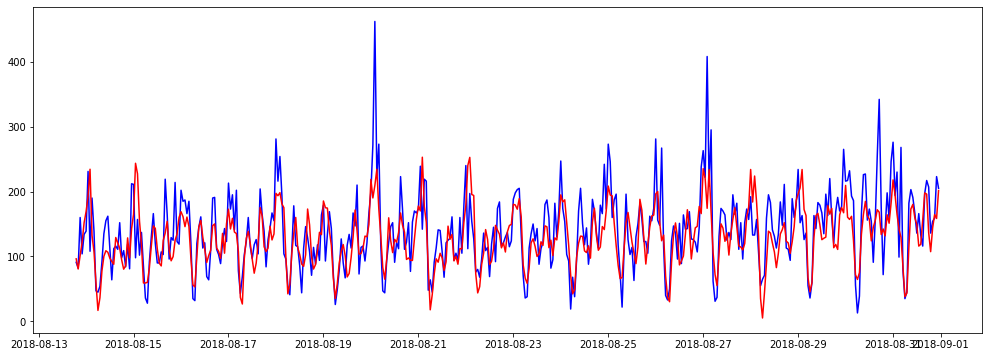

In [27]:
model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5
print(rmse_lr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')
plt.show()

### Catboost

41.18395579510713


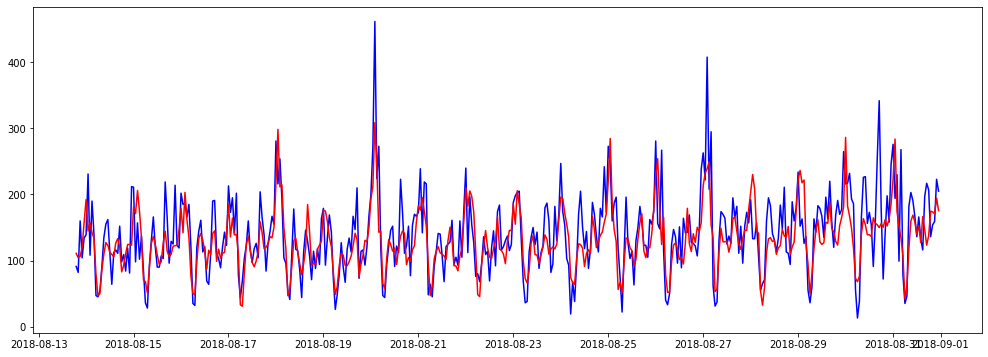

In [28]:
modelCat = CatBoostRegressor(depth = 3, iterations = 300, learning_rate = 0.1, verbose= False)
modelCat.fit(features_train, target_train)
modelCat_predict = modelCat.predict(features_test)
rmse_cbr = mean_squared_error(target_test, modelCat_predict) ** 0.5
print(rmse_cbr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, modelCat_predict,'r-')
plt.show()

### LightGBM

In [29]:
LGBMR = LGBMRegressor(max_depth = 3, learning_rate = 0.03, random_state = 42)
LGBMR.fit(features_train, target_train)
target_predict = LGBMR.predict(features_test)
rmse_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

In [30]:
print(rmse_LGBMR)

45.16633375681024


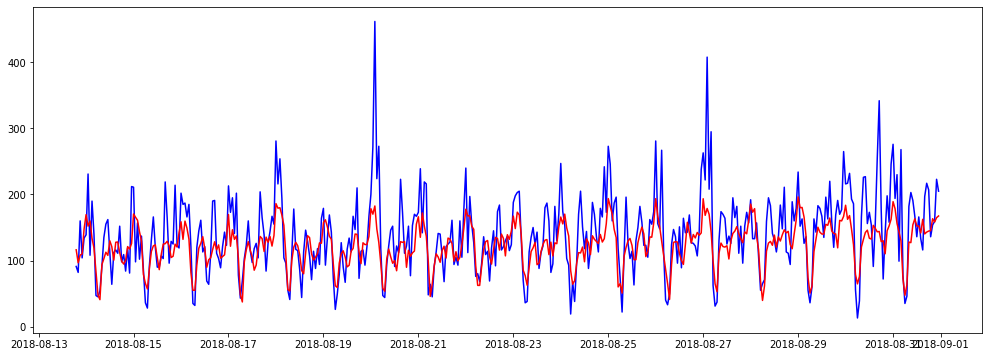

In [31]:
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')
plt.show()

### Сравнение моделей

In [32]:
predictive_model_scores = pd.DataFrame(data=[('Linear Regression',rmse_lr), 
                                             ('LGBMRegressor', rmse_LGBMR),
                                            ('CatBoost',rmse_cbr)],
                                       columns=['model', 'testing_rmse'])
predictive_model_scores

,model,testing_rmse
0,Linear Regression,43.242537
1,LGBMRegressor,45.166334
2,CatBoost,41.183956


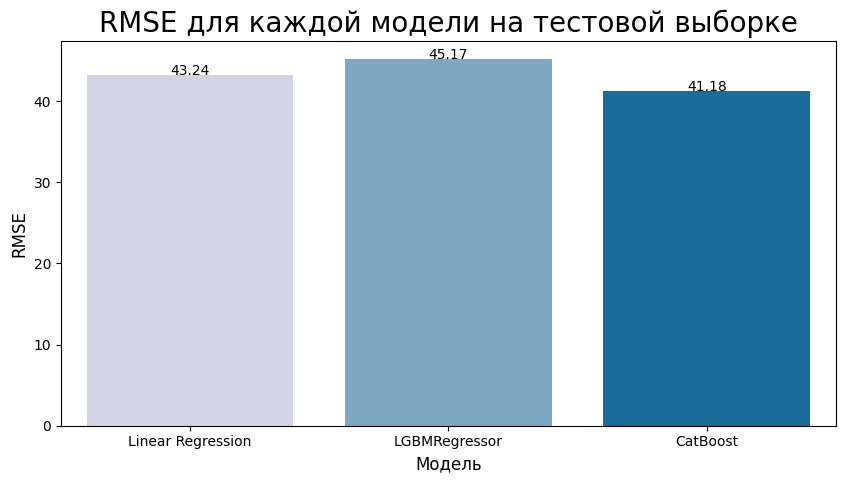

In [33]:
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='model', y='testing_rmse', data=predictive_model_scores, palette='PuBu')
plt.title('RMSE для каждой модели на тестовой выборке', fontsize = 20)
plt.xlabel('Модель', fontsize = 12)
plt.ylabel('RMSE', fontsize = 12)
for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_rmse, s=round(row.testing_rmse,2), color='black', horizontalalignment='center');

Согласно полученным значениям, лучшей моделью становится catboost, со значением метрики RMSE 41.18 на тестовой выборке

## Вывод

Согласно проведенному исследованию можно заявить, что разработанная модель способна улучшить алгоритм привлечения водителей. На тестовых данных лучшая модель показала значение метрики RMSE 41.18, что удовлетворяет поставленным требованиям

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48